## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from helper_methods import run, plot

## Agent Implementation

In [18]:
class QTable:
    def __init__(self):
        self.q_table = {}
        self.initial = -0
        
    def state_exists(self, state):
        return tuple(state) in self.q_table
    
    def get_actions(self, state):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*4)
    
    def get_action_value(self, state, action_index):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*4)[action_index]
    
    def set_action_value(self, state, action_index, action_value):
        if not self.state_exists(state):
            self.q_table[tuple(state)] = [self.initial]*4
        self.q_table[tuple(state)][action_index] = action_value 

class QLearningAgent:

    def __init__(self, env,number_bins):
        self.num_of_actions = env.action_space.n
        #self.state_space =
        self.env = env
        self.number_bins = number_bins
        
        self.q_table = QTable() 
        
        # hyper parameters
        self.discount = 0.99 #gamma
        self.learning_rate = 0.2 #step size, alpha
        self.episodes = 300
        self.decrease_factor = 0.01 #epislon
        
        
    def continous_to_discrete(self,continous,highest=600000000,lowest=0):
        bins = np.linspace(lowest,highest,num=self.number_bins)
        discrete = np.digitize(continous,bins)
        return discrete
    
    def run_all_episodes(self):
        all_rewards = []
        epislon = 1 #at the start only explore
        
        for episode in range(self.episodes):
            if episode % 20 == 0:
                print("Currently in episode number: " + str(episode + 1))
            rewards = self.run_episode(epislon)
            all_rewards.append(np.sum(rewards))
            epislon -= self.decrease_factor #hyperparameter
            
        return all_rewards
    
    def run_episode(self,epislon):
        states = []
        rewards = []
        done = False
        
        
        state = self.env.reset()
        state = self.continous_to_discrete(state)

        states.append(state)
        
        while not done:
            random_number = np.random.randint(0,1)
            if random_number < epislon:
                #explore
                action = np.random.choice(self.num_of_actions)
            else:
                #exploit
                action = self.get_action(state)
                
            new_state, reward, done, i = self.env.step(action=action) # Q-learning
            new_state = self.continous_to_discrete(new_state)
            
            #update q table
            self.update_q_table(state,new_state,action,reward)
            
            states.append(state)
            rewards.append(reward)
            state = new_state
        return rewards
    
    def update_q_table(self,state,new_state,action,reward):
        #target
        #max of a' given the 
        max_a_prime = np.max(self.q_table.get_actions(new_state))
        target = reward + (self.discount*max_a_prime)
        
        #compute difference
        difference = target - self.q_table.get_action_value(state,action)
        
        #take a small step in the delta direction
        new_q = self.q_table.get_action_value(state,action) + (self.learning_rate * difference)
        
        self.q_table.set_action_value(state,action,new_q)
        
    
    def get_action(self,state):
        #exploit the q table
        action = np.argmax(self.q_table.get_actions(state))
        return action
            
            
    def get_action_text(self,action):
        action_texts = ["no intervention", "impose a full lockdown", "implement track & trace", "enforce social distancing and face masks"]
        return action_texts[action]
    
    def get_env(self):
        return env
    
    def get_chart_title(self):
        return "Title here"


## Analysis

In [19]:
from matplotlib import pyplot as plt

env = virl.Epidemic(stochastic=False, noisy=False)

agent = QLearningAgent(env,20)
rewards = agent.run_all_episodes()



Currently in episode number: 1
Currently in episode number: 21
Currently in episode number: 41
Currently in episode number: 61
Currently in episode number: 81
Currently in episode number: 101
Currently in episode number: 121
Currently in episode number: 141
Currently in episode number: 161
Currently in episode number: 181
Currently in episode number: 201
Currently in episode number: 221
Currently in episode number: 241
Currently in episode number: 261
Currently in episode number: 281


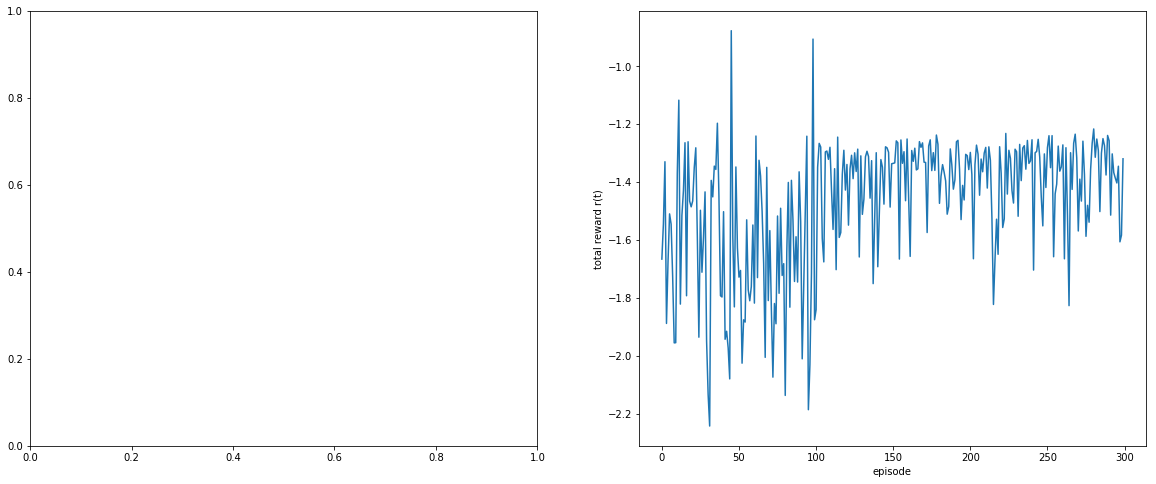

In [20]:
def plot(agent, rewards):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[1].plot(rewards);
    axes[1].set_xlabel('episode')
    axes[1].set_ylabel('total reward r(t)')
    
plot(agent, rewards)

## Evaluation

Eval here